In [271]:
import numpy as np
import galsim
import matplotlib.pyplot as plt
%matplotlib inline 

import galsim_galaxy as gg
reload(gg)

colors = ['#348ABD', '#7A68A6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33']

In [296]:
ngrid_lsst = 70

pixscale_wfirst = 0.11

filter_name_ground='r'
filter_name_space='r'

galaxy_model="Spergel"

active_parameters = ['nu', 'hlr', 'e', 'beta', 'flux_sed1']

In [297]:
lsst = gg.GalSimGalaxyModel(pixel_scale=0.2,
        noise=gg.lsst_noise(82357),
        galaxy_model=galaxy_model,
        active_parameters=active_parameters,
        wavelength=gg.k_filter_central_wavelengths[filter_name_ground] * 1.e-9,
        primary_diam_meters=8.4,
        atmosphere=True)

In [298]:
wfirst = gg.GalSimGalaxyModel(pixel_scale=pixscale_wfirst,
        noise=gg.wfirst_noise(82357),
        galaxy_model=galaxy_model,
        active_parameters=active_parameters,
        wavelength=gg.k_filter_central_wavelengths[filter_name_space] * 1.e-9,
        primary_diam_meters=2.4,
        atmosphere=False)

ngrid_wfirst = np.ceil(ngrid_lsst * lsst.pixel_scale / wfirst.pixel_scale)

In [299]:
lsst_model = gg.GalSimGalaxyModel(pixel_scale=0.2,
            noise=gg.lsst_noise(82357),
            galaxy_model=galaxy_model,
            active_parameters=active_parameters,
            wavelength=gg.k_filter_central_wavelengths[filter_name_ground] * 1.e-9,
            primary_diam_meters=8.4,
            atmosphere=True)
wfirst_model = gg.GalSimGalaxyModel(pixel_scale=pixscale_wfirst,
            noise=gg.wfirst_noise(82357),
            galaxy_model=galaxy_model,
            active_parameters=active_parameters,
            wavelength=gg.k_filter_central_wavelengths[filter_name_space] * 1.e-9,
            primary_diam_meters=2.4,
            atmosphere=False)

In [300]:
### Galaxy model parameters for Spergel profile
### (nu, hlr, e, beta)
params = [-0.6, 1.0, 0., 0., np.log(1.e4)]

lsst.set_params(params)
wfirst.set_params(params)

lsst_model.set_params(params)
wfirst_model.set_params(params)

In [301]:
nsamples = 100
SNRs = [None, 1, 50, 100000]

lsst_images = [[lsst.get_image(out_image=galsim.Image(ngrid_lsst, ngrid_lsst), 
                               add_noise=True,
                               filter_name=filter_name_ground,
                               snr=snr) for i in xrange(nsamples)] for snr in SNRs]

wfirst_images = [[wfirst.get_image(out_image=galsim.Image(ngrid_wfirst, ngrid_wfirst), 
                                   add_noise=True,
                                   filter_name=filter_name_space,
                                   snr=snr) for i in xrange(nsamples)] for snr in SNRs]

<matplotlib.colorbar.Colorbar instance at 0x125c45518>

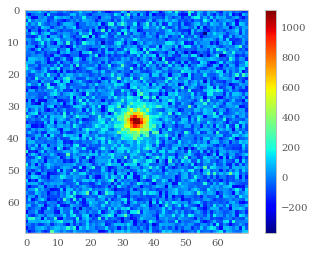

In [302]:
plt.imshow(lsst_images[0][0].array, interpolation='none')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x125daab48>

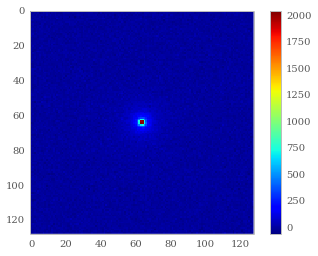

In [303]:
plt.imshow(wfirst_images[0][0].array, interpolation='none')
plt.colorbar()

In [304]:
lsst_model_im = lsst_model.get_image(out_image=galsim.Image(ngrid_lsst, ngrid_lsst), 
                                     add_noise=False,
                                     filter_name=filter_name_ground)

wfirst_model_im = wfirst_model.get_image(out_image=galsim.Image(ngrid_wfirst, ngrid_wfirst), 
                                         add_noise=False,
                                         filter_name=filter_name_space)

<matplotlib.colorbar.Colorbar instance at 0x125f98b90>

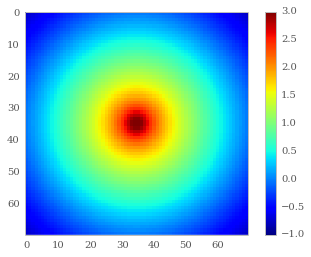

In [305]:
plt.imshow(np.log10(lsst_model_im.array), interpolation='none', vmin=-1, vmax=3)
plt.colorbar()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


<matplotlib.colorbar.Colorbar instance at 0x1261531b8>

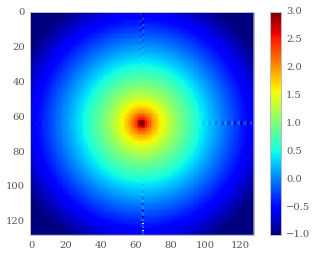

In [306]:
plt.imshow(np.log10(wfirst_model_im.array), interpolation='none', vmin=-1, vmax=3)
plt.colorbar()

In [307]:
lsst_arrays = [[im.array for im in images] for images in lsst_images]
wfirst_arrays = [[im.array for im in images] for images in wfirst_images]

np.array(lsst_arrays[0]).shape

(100, 70, 70)

In [308]:
lsst_rms = [np.sqrt(np.var(np.array(ar), axis=0)) for ar in lsst_arrays]
wfirst_rms = [np.sqrt(np.var(np.array(ar), axis=0)) for ar in wfirst_arrays]
print(lsst_rms[0].shape)
print(wfirst_rms[0].shape)

(70, 70)
(128, 128)


<matplotlib.colorbar.Colorbar instance at 0x127e7da28>

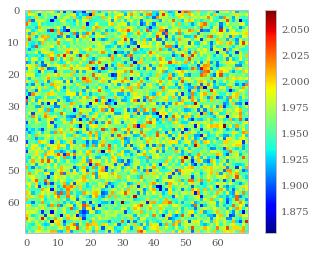

In [309]:
plt.imshow(np.log10(lsst_rms[0]), interpolation='none')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x1280275f0>

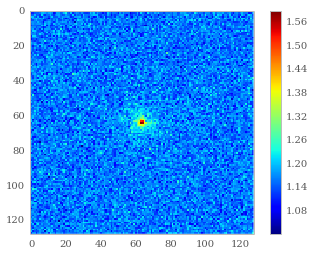

In [310]:
plt.imshow(np.log10(wfirst_rms[0]), interpolation='none')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x128241830>

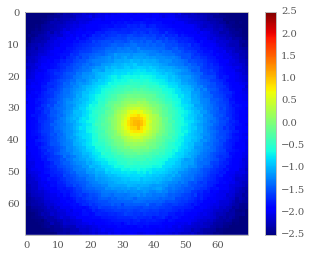

In [311]:
plt.imshow(np.log10(lsst_model_im.array / lsst_rms[0]), interpolation='none', vmin=-2.5, vmax=2.5)
plt.colorbar()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


<matplotlib.colorbar.Colorbar instance at 0x1283f2fc8>

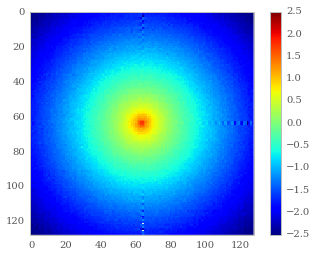

In [312]:
plt.imshow(np.log10(wfirst_model_im.array / wfirst_rms[0]), interpolation='none', vmin=-2.5, vmax=2.5)
plt.colorbar()

In [313]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is
             None, which then uses the center of the image (including
             fracitonal pixels).
    http://www.astrobetter.com/wiki/tiki-index.php?page=python_radial_profiles
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin

    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof #/ np.sqrt(nr)

In [314]:
lsst_profiles = [azimuthalAverage(lsst_model_im.array / rms) for rms in lsst_rms]
wfirst_profiles = [azimuthalAverage(wfirst_model_im.array / rms) for rms in wfirst_rms]

# lsst_profiles = [azimuthalAverage(lsst_model_im.array)]
# wfirst_profiles = [azimuthalAverage(wfirst_model_im.array)]

# lsst_profiles = [lsst_model_im.array[35:70,35]]
# wfirst_profiles = [wfirst_model_im.array[64:128, 64]]

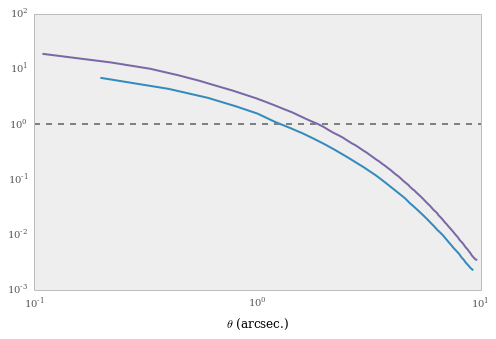

In [315]:
theta_lsst = np.arange(len(lsst_profiles[0])) * 0.2
theta_wfirst = np.arange(len(wfirst_profiles[0])) * pixscale_wfirst

# f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(6, 8))
# for i, snr in enumerate(SNRs):
# #     plt.subplot(len(SNRs), 1, i+1)
#     axarr[i].loglog(theta_lsst, lsst_profiles[i], color=colors[0])
#     axarr[i].loglog(theta_wfirst, wfirst_profiles[i], color=colors[1])
#     axarr[i].axhline(1, color='grey', linestyle='dashed')
#     axarr[i].axvline(0.8, color='grey', linestyle='dashed')
# plt.tight_layout()

fig = plt.figure(figsize=(8, 8/1.618))
plt.loglog(theta_lsst, lsst_profiles[0])
# plt.loglog(theta_lsst, lsst_profiles[0], color=colors[0], linestyle='dashed')
plt.loglog(theta_wfirst, wfirst_profiles[0], color=colors[1])
# plt.loglog(theta_wfirst, wfirst_profiles[0], color=colors[1], linestyle='dashed')
plt.axhline(1, color='grey', linestyle='dashed')

plt.xlabel(r"$\theta$ (arcsec.)")

# plt.ylim(0.01, 50)

In [316]:
print([rms.min() for rms in lsst_rms])
print([rms.mean() for rms in lsst_rms])
print([rms.max() for rms in lsst_rms])

[71.651466, 68.476433, 71.020058, 69.229881]
[92.051018, 91.810692, 91.997131, 129.98268]
[117.24988, 114.71497, 125.75665, 994.93488]


## Old stuff

In [1035]:
lsst_profiles = [[azimuthalAverage(im.array) for im in images] 
                 for images in lsst_images]

wfirst_profiles = [[azimuthalAverage(im.array) for im in images] 
                   for images in wfirst_images]

In [1036]:
np.array(lsst_profiles).shape

(4, 200, 47)

In [1037]:
lsst_sb_var = [np.var(np.array(sb), axis=0) / 0.2**4 for sb in lsst_profiles]
wfirst_sb_var = [np.var(np.array(sb), axis=0) / pixscale_wfirst**4 for sb in wfirst_profiles]

In [1038]:
lsst_sb = [np.mean(np.array(sb), axis=0) / 0.2**2 for sb in lsst_profiles]
wfirst_sb = [np.mean(np.array(sb), axis=0) / pixscale_wfirst**2 for sb in wfirst_profiles]

(10.0, 1000.0)

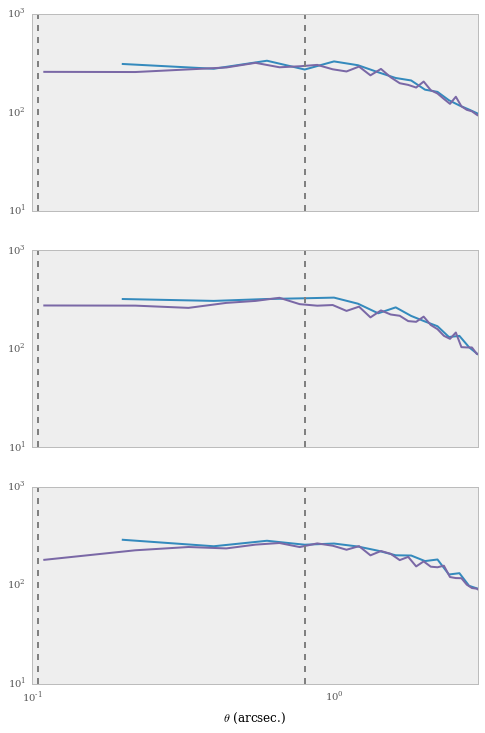

In [1045]:
theta_lsst = np.arange(len(lsst_sb[0])) * 0.2
theta_wfirst = np.arange(len(wfirst_sb[0])) * pixscale_wfirst

# fig = plt.figure(figsize=(12,8/1.618))
f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(8, 12))

linestyles = ['-', '--', '-.', ':']

for isnr, snr in enumerate(SNRs[1:]):
    axarr[isnr].loglog(theta_lsst, 3*lsst_sb[0] / np.sqrt(lsst_sb_var[isnr+1]), 
               color=colors[0])
    axarr[isnr].loglog(theta_wfirst, wfirst_sb[0] / np.sqrt(wfirst_sb_var[isnr+1]), 
               color=colors[1])
    axarr[isnr].axvline(0.8, color='grey', linestyle='dashed')
    axarr[isnr].axvline(1.22*(gg.k_filter_central_wavelengths[filter_name_space] * 1.e-9 / 2.4) * 180.*3600/np.pi, 
                              color='grey', linestyle='dashed')

# plt.loglog(theta_lsst[1:], (lsst_sb[0] / np.sqrt(np.abs(lsst_sb[1])))[1:], label="LSST")
# plt.loglog(theta_wfirst[1:], (wfirst_sb[0] / np.sqrt(np.abs(wfirst_sb[1])))[1:], label="WFIRST")

plt.xlabel(r"$\theta$ (arcsec.)")
# plt.ylabel(r"Surface brightness / Noise RMS")
# plt.legend()

# plt.axhline(8e2, color='grey')

# plt.axvline(0.8, color='grey', linestyle='dashed')
# plt.axvline(1.22*(gg.k_filter_central_wavelengths[filter_name_space] * 1.e-9 / 2.4) * 180.*3600/np.pi, 
#             color='grey', linestyle='dashed')

plt.xlim(1e-1, 3)
plt.ylim(1e1, 1e3)
# plt.ylim(1, 10)

This is a function of:

- WFIRST pixel scale (and sub-pixel dithers)
- LSST seeing
- galaxy profile slope
- noise rms 